In [1]:
import pandas as pd
import findspark
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time

# Бібліотеки для візуалізації в PySpark
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

In [2]:
# Ініціалізація findspark для використання Spark
findspark.init()

In [47]:
# Завантаження даних електронної комерції за жовтень та листопад 2019 року
df_oct = pd.read_csv('2019-Oct.csv')
df_nov = pd.read_csv('2019-Nov.csv')

# Об'єднання наборів даних в один DataFrame
df = pd.concat([df_oct, df_nov], ignore_index=True)

# Звільнення пам'яті від окремих місяців
del df_oct, df_nov

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Початкова інформація про дані
print("Початкова інформація про дані:")
print(df.info())

# Приклад перших 5 рядків
print("\nПриклад даних:")
print(df.head())

# Перевірка на пропущені значення
print("\nПропущені значення у кожному стовпці:")
print(df.isnull().sum())

# Базова статистика
print("\nСтатистичний огляд:")
print(df.describe())

Початкова інформація про дані:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109950743 entries, 0 to 109950742
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 7.4+ GB
None

Приклад даних:
                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   

                 

In [ ]:
# Видалення записів з відсутніми або некоректними значеннями 'price'
df = df.dropna(subset=['price'])      # Видалення записів з відсутніми цінами
df = df[df['price'] > 0]              # Видалення записів з ціною <= 0

# Заповнення пропусків у 'category_code' та 'brand' значенням 'unknown'
df['category_code'].fillna('unknown', inplace=True)
df['brand'].fillna('unknown', inplace=True)

# Видалення записів з відсутніми 'user_session'
df.dropna(subset=['user_session'], inplace=True)

# Видалення дублікатів
df = df.drop_duplicates()

# Перетворення категоріального 'event_type' у числові значення
df['event_type'] = df['event_type'].map({'view': 0, 'cart': 1, 'purchase': 2})

# Конвертація 'event_time' у datetime та створення додаткових часових стовпців
df['event_time'] = pd.to_datetime(df['event_time'])
df['hour'] = df['event_time'].dt.hour
df['day_of_week'] = df['event_time'].dt.dayofweek

/var/folders/7h/3w921_vx6tngbk9tj6c3x70h0000gn/T/ipykernel_55719/3787710340.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category_code'].fillna('unknown', inplace=True)
/var/folders/7h/3w921_vx6tngbk9tj6c3x70h0000gn/T/ipykernel_55719/3787710340.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [ ]:
df['category_code'] = df['category_code'].fillna('unknown')
df['brand'] = df['brand'].fillna('unknown')

In [ ]:
# Нормалізація стовпця 'price' для покращення аналізу
scaler = StandardScaler()
df['price_normalized'] = scaler.fit_transform(df[['price']])

# За потреби можна видалити оригінальний стовпець 'price'
# df.drop(columns=['price'], inplace=True)

In [ ]:
# Збереження очищених даних у форматі Parquet для обробки у PySpark
df.to_parquet('cleaned_ecommerce_data.parquet', index=False)


Кількість подій за типами:
event_type
0    104079641
1      3823991
2      1659703
Name: count, dtype: int64


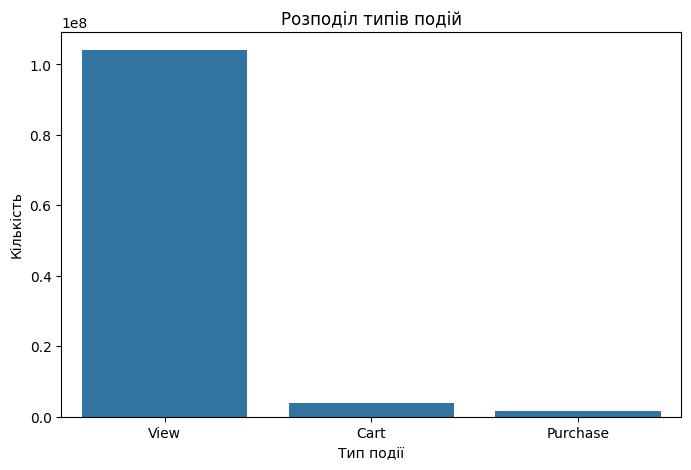

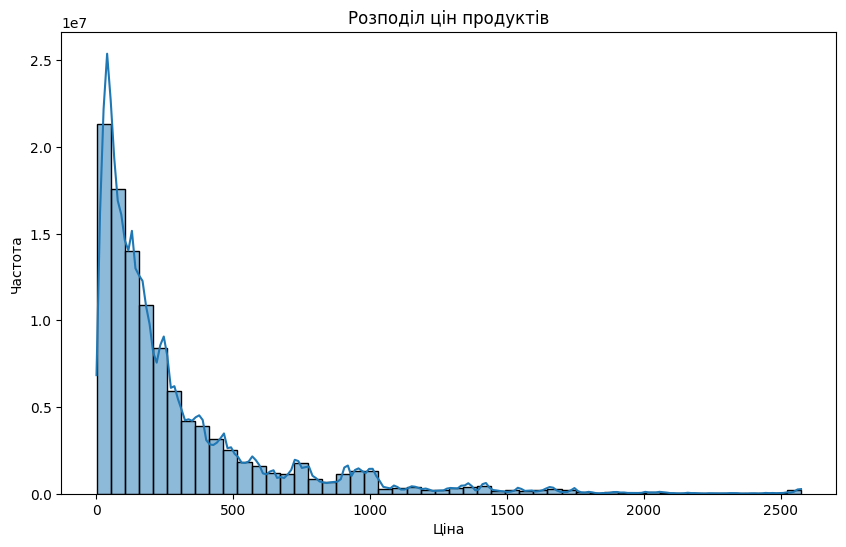

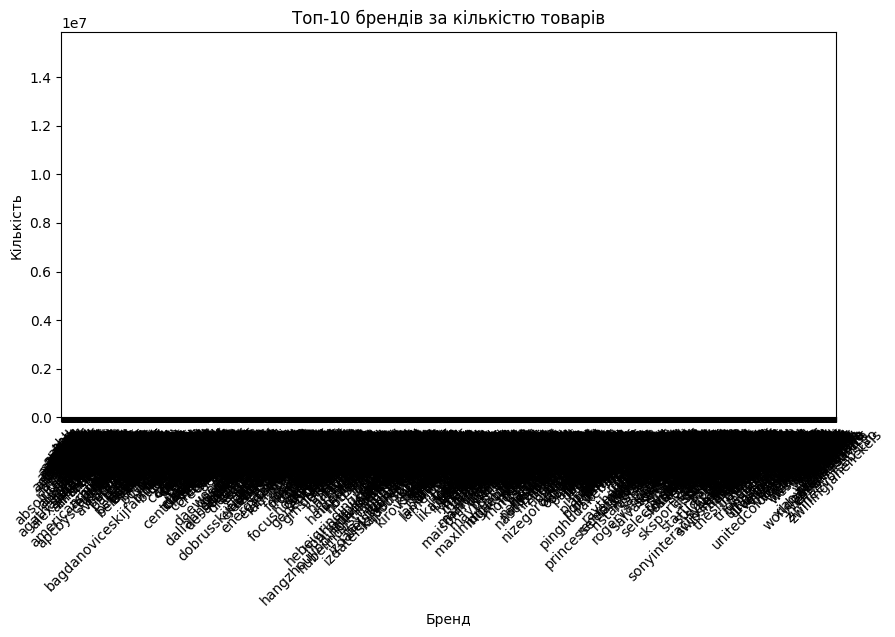

In [ ]:
# Аналіз типів подій
print("\nКількість подій за типами:")
print(df['event_type'].value_counts())

# Візуалізація розподілу типів подій
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='event_type', order=sorted(df['event_type'].unique()))
plt.title('Розподіл типів подій')
plt.xlabel('Тип події')
plt.ylabel('Кількість')
plt.xticks([0, 1, 2], ['View', 'Cart', 'Purchase'])
plt.show()

# Візуалізація розподілу цін
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Розподіл цін продуктів')
plt.xlabel('Ціна')
plt.ylabel('Частота')
plt.show()

# Топ-10 брендів за кількістю товарів
top_brands = df['brand'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_brands.index, y=top_brands.values)
plt.title('Топ-10 брендів за кількістю товарів')
plt.xlabel('Бренд')
plt.ylabel('Кількість')
plt.xticks(rotation=45)
plt.show()

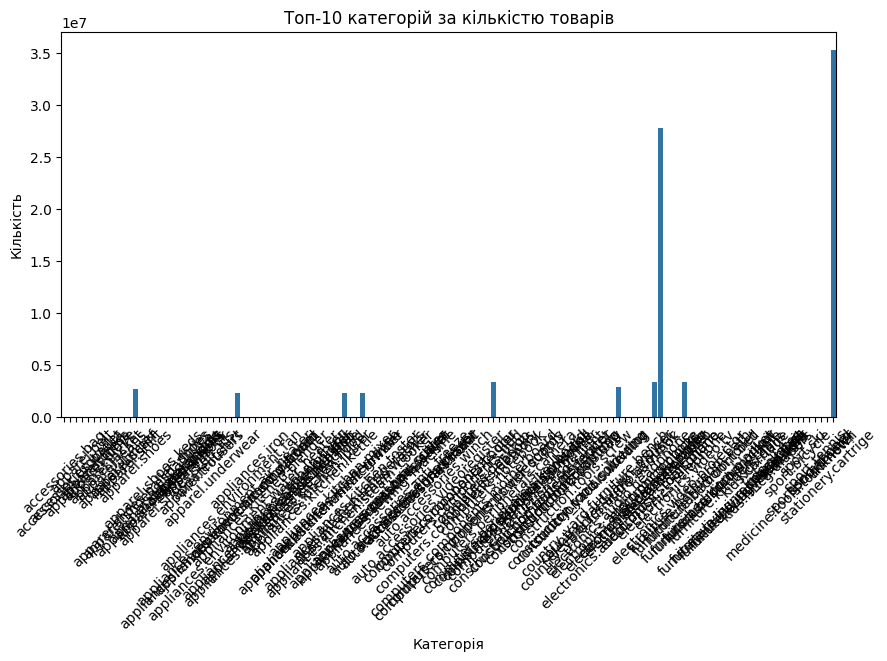

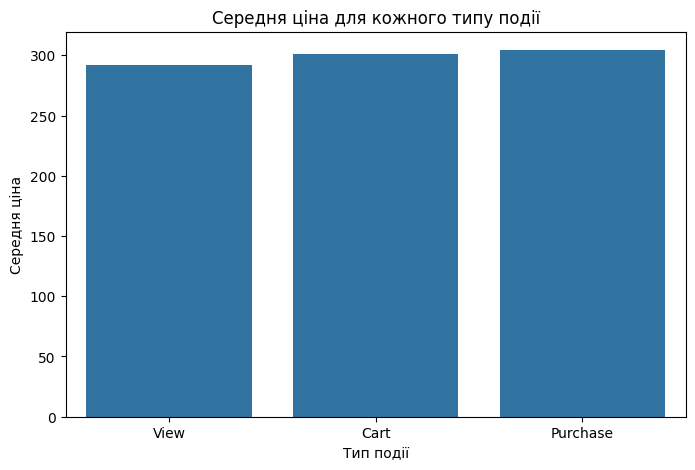

In [ ]:
# Топ-10 категорій за кількістю товарів
top_categories = df['category_code'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.title('Топ-10 категорій за кількістю товарів')
plt.xlabel('Категорія')
plt.ylabel('Кількість')
plt.xticks(rotation=45)
plt.show()

# Середня ціна для кожного типу події
avg_price_per_event = df.groupby('event_type')['price'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_price_per_event.index, y=avg_price_per_event.values)
plt.title('Середня ціна для кожного типу події')
plt.xlabel('Тип події')
plt.ylabel('Середня ціна')
plt.xticks([0, 1, 2], ['View', 'Cart', 'Purchase'])
plt.show()

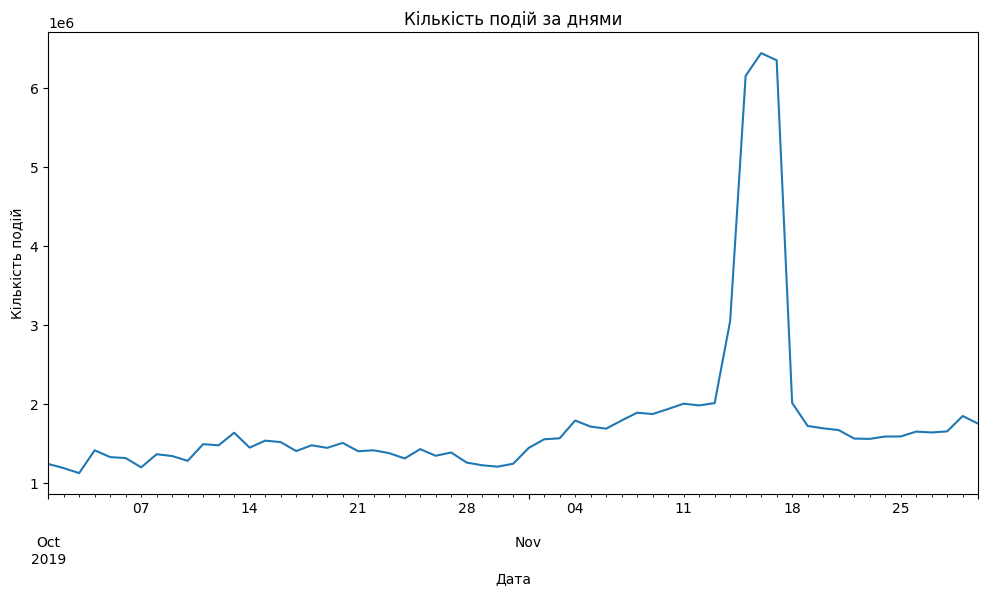

In [ ]:
# Ресемплінг даних за днями та побудова графіка щоденної кількості подій
df.set_index('event_time', inplace=True)
daily_counts = df.resample('D').size()
plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title('Кількість подій за днями')
plt.xlabel('Дата')
plt.ylabel('Кількість подій')
plt.show()

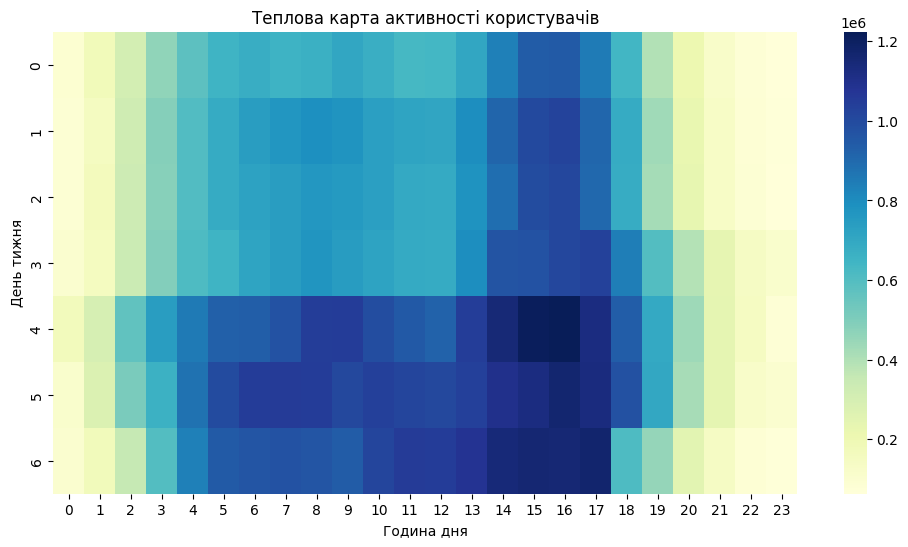

In [ ]:
# Теплова карта активності користувачів за днем тижня та годиною
activity = df.groupby(['day_of_week', 'hour']).size().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(activity, cmap="YlGnBu")
plt.title('Теплова карта активності користувачів')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.show()

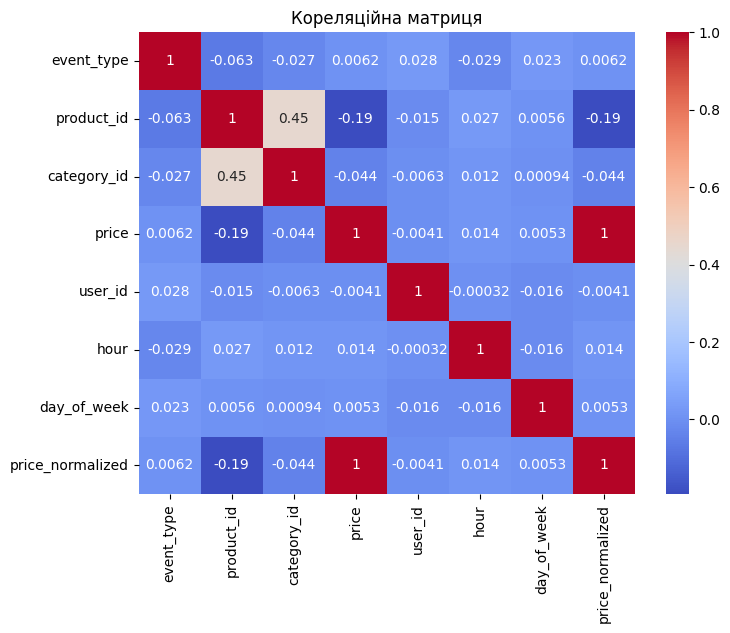

In [ ]:
# Вибір числових стовпців для кореляційного аналізу
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Кореляційна матриця')
plt.show()

In [ ]:
from pyspark.sql import SparkSession

# Ініціалізація Spark Session
spark = SparkSession.builder.appName("E-commerce Analysis").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Завантаження очищених даних у Spark DataFrame
spark_df = spark.read.parquet('cleaned_ecommerce_data.parquet')

# Перетворення типів даних
from pyspark.sql.types import DoubleType, IntegerType

spark_df = spark_df.withColumn("event_type", spark_df["event_type"].cast(IntegerType()))
spark_df = spark_df.withColumn("price_normalized", spark_df["price_normalized"].cast(DoubleType()))
spark_df = spark_df.withColumn("hour", spark_df["hour"].cast(IntegerType()))
spark_df = spark_df.withColumn("day_of_week", spark_df["day_of_week"].cast(IntegerType()))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/02 23:57:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Кодування категоріальних змінних за допомогою StringIndexer та OneHotEncoder
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Кодування 'category_code'
category_indexer = StringIndexer(inputCol='category_code', outputCol='category_index')
spark_df = category_indexer.fit(spark_df).transform(spark_df)

# Кодування 'brand'
brand_indexer = StringIndexer(inputCol='brand', outputCol='brand_index')
spark_df = brand_indexer.fit(spark_df).transform(spark_df)

24/11/02 23:57:41 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
# Вибір вхідних стовпців для моделі
input_cols = ['event_type', 'price_normalized', 'hour', 'day_of_week', 'category_index', 'brand_index']

# Створення вектора ознак
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
assembled_data = assembler.transform(spark_df)

In [6]:
# Вибір кількості кластерів K
k = 5

# Ініціалізація KMeans моделі
kmeans = KMeans().setK(k).setSeed(1)

# Навчання моделі
model = kmeans.fit(assembled_data.select('features'))

# Отримання передбачень кластерів
clusters = model.transform(assembled_data)

24/11/02 23:57:59 WARN MemoryStore: Not enough space to cache rdd_42_4 in memory! (computed 27.7 MiB so far)
24/11/02 23:57:59 WARN BlockManager: Persisting block rdd_42_4 to disk instead.
24/11/02 23:57:59 WARN MemoryStore: Not enough space to cache rdd_42_9 in memory! (computed 27.7 MiB so far)
24/11/02 23:57:59 WARN BlockManager: Persisting block rdd_42_9 to disk instead.
24/11/02 23:57:59 WARN MemoryStore: Not enough space to cache rdd_42_0 in memory! (computed 27.7 MiB so far)
24/11/02 23:57:59 WARN BlockManager: Persisting block rdd_42_0 to disk instead.
24/11/02 23:57:59 WARN MemoryStore: Not enough space to cache rdd_42_1 in memory! (computed 27.7 MiB so far)
24/11/02 23:57:59 WARN BlockManager: Persisting block rdd_42_1 to disk instead.
24/11/02 23:57:59 WARN MemoryStore: Not enough space to cache rdd_42_7 in memory! (computed 27.7 MiB so far)
24/11/02 23:57:59 WARN BlockManager: Persisting block rdd_42_7 to disk instead.
24/11/02 23:57:59 WARN MemoryStore: Not enough space to

In [7]:
# Використання ClusteringEvaluator для оцінки моделі
evaluator = ClusteringEvaluator()

# Обчислення Silhouette Score
silhouette = evaluator.evaluate(clusters)
print(f"Silhouette Score з квадратною евклідовою відстанню: {silhouette}")

Silhouette Score з квадратною евклідовою відстанню: 0.8806702540763036


In [8]:
# Підрахунок кількості записів у кожному кластері
cluster_counts = clusters.groupBy('prediction').count().orderBy('prediction')
cluster_counts.show()

# Огляд центрів кластерів
centers = model.clusterCenters()
print("Координати центрів кластерів:")
for idx, center in enumerate(centers):
    print(f"Кластер {idx}: {center}")

+----------+--------+
|prediction|   count|
+----------+--------+
|         0|89012344|
|         1| 5080761|
|         2|  650845|
|         3| 2107570|
|         4|12711815|
+----------+--------+

Координати центрів кластерів:
Кластер 0: [ 0.07180466  0.06982122 11.22134192  3.26672656  7.14523032 17.48134764]
Кластер 1: [ 3.19433425e-02 -2.87766177e-01  1.15167995e+01  3.25606579e+00
  1.62593071e+01  6.23720252e+02]
Кластер 2: [ 2.44768561e-02 -3.15597227e-01  1.16657775e+01  3.22245497e+00
  1.47166568e+01  2.30522323e+03]
Кластер 3: [ 2.88831609e-02 -2.33492826e-01  1.15929936e+01  3.24004142e+00
  1.86325853e+01  1.24807644e+03]
Кластер 4: [ 4.06464993e-02 -3.15973986e-01  1.13527950e+01  3.23416983e+00
  1.45013616e+01  2.34901701e+02]


In [ ]:
# Приєднання оригінальних даних для аналізу кластерів
selected_columns = ['event_type', 'price_normalized', 'hour', 'day_of_week', 'category_index', 'brand_index', 'prediction']
clusters_pd = clusters.select(*selected_columns).limit(10000).toPandas()
# Інвертування індексів до оригінальних категорій
category_labels = category_indexer.labels
brand_labels = brand_indexer.labels

clusters_pd['category_code'] = clusters_pd['category_index'].apply(lambda x: category_labels[int(x)])
clusters_pd['brand'] = clusters_pd['brand_index'].apply(lambda x: brand_labels[int(x)])

# Аналіз середніх значень ознак для кожного кластера
cluster_summary = clusters_pd.groupby('prediction').mean()
print(cluster_summary)

AttributeError: 'StringIndexer' object has no attribute 'labels'

24/11/03 06:01:00 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 5120203 ms exceeds timeout 120000 ms
24/11/03 06:01:00 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/03 06:01:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [ ]:
# Візуалізація кластерів за двома головними компонентами
from pyspark.ml.feature import PCA

# Виконання PCA для зменшення розмірності до 2 компонентів
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(assembled_data)
pca_result = pca_model.transform(assembled_data)

# Додавання передбачень кластерів
pca_result = pca_result.select("pcaFeatures", "prediction")

# Перетворення в Pandas DataFrame
pca_pd = pca_result.select("pcaFeatures", "prediction").toPandas()
pca_pd[['pc1', 'pc2']] = pd.DataFrame(pca_pd['pcaFeatures'].tolist(), index=pca_pd.index)

# Візуалізація
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pc1', y='pc2', hue='prediction', data=pca_pd, palette='viridis')
plt.title('Візуалізація кластерів після PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
# Вимірювання часу обробки в PySpark
start_time = time.time()
popular_products_spark = spark_df.groupBy('category_code').count().orderBy('count', ascending=False)
popular_products_spark.show(10)
end_time = time.time()
print(f"Час обробки в PySpark: {end_time - start_time:.2f} секунд")

# Вимірювання часу обробки в Pandas
start_time = time.time()
popular_products_pandas = df['category_code'].value_counts().head(10)
print(popular_products_pandas)
end_time = time.time()
print(f"Час обробки в Pandas: {end_time - start_time:.2f} секунд")

In [ ]:
# Зупинка Spark Session
spark.stop()